# Connecting the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Image-Captioning')

# Importing neccessary libraries

In [3]:
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Dropout, LSTM, Embedding, add, Input
from keras.models import Model

# Load preprocess images, captions, and tokenizer

In [4]:
# load caption
with open("Preprocessing/captions_dict.pkl", "rb") as f:
  captions_dict = pickle.load(f)
with open("Preprocessing/all_captions.pkl", "rb") as f:
  all_captions = pickle.load(f)

# load image features
with open("Preprocessing/features.pkl", "rb") as f:
  img_features = pickle.load(f)

# load tokenizer
with open("Preprocessing/tokenizer.pkl", "rb") as f:
  tokenizer = pickle.load(f)

In [ ]:
captions_dict['1000268201_693b08cb0e'], all_captions[5:10]

(['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>',
  '<startseq> girl going into wooden building <endseq>',
  '<startseq> little girl climbing into wooden playhouse <endseq>',
  '<startseq> little girl climbing the stairs to her playhouse <endseq>',
  '<startseq> little girl in pink dress going into wooden cabin <endseq>'],
 ['<startseq> black dog and spotted dog are fighting <endseq>',
  '<startseq> black dog and tri-colored dog playing with each other on the road <endseq>',
  '<startseq> black dog and white dog with brown spots are staring at each other in the street <endseq>',
  '<startseq> two dogs of different breeds looking at each other on the road <endseq>',
  '<startseq> two dogs on pavement moving toward each other <endseq>'])

In [ ]:
img_features['1000268201_693b08cb0e']

array([[2.5074754, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
tokenizer.word_index['dog']

8

# Vocab size and maxlen

In [5]:
vocab_size = len(tokenizer.word_index)+1
max_len = max(len(caption.split()) for caption in all_captions)

In [6]:
vocab_size, max_len

(8485, 35)

# Train Test Split

In [7]:
imageIds = list(captions_dict.keys())
split = int(len(imageIds) * 0.90)
train = imageIds[:split]
test = imageIds[split:]

In [8]:
len(train), len(test)

(7281, 810)

# Data Generator Function

we have ram less than 16 gb, so if we directly train our model it will crash as we have large number of dataset and vocabulary, so we will create a data genrator functon to avoid crashing

In [9]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    def generator():
        X1, X2, y = list(), list(), list()
        n = 0
        while True:
            for key in data_keys:
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
                if len(X1) >= batch_size:
                    yield ((np.array(X1), np.array(X2)), np.array(y))
                    X1, X2, y = list(), list(), list()

    output_signature = (
        (
            tf.TensorSpec(shape=(None, features[data_keys[0]].shape[1]), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32),
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)


In [ ]:
# how we are creating the pairs (X, y)
# let's take an example: '<startseq> girl going into wooden building <endseq>'

#  X1                         X2                                  y
# image        <startseq>                                        girl
# image        <startseq> girl                                   going
# image        <startseq> girl going                             into
# image        <startseq> girl going into                        wooden
# image        <startseq> girl going into wooden                 building
# image        <startseq> girl going into wooden building        <endseq>


# we are giving input and geting the ouput and for next iteration we are having input as input+output
# and having the ouput and doing unitill we reach at <endseq> token

# Model Building

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

def define_model(input_features, vocab_size, max_len):
    # ---- encoder model ------
    # image features layer
    inputs1 = Input(shape=(input_features,))
    fe1 = Dropout(0.4)(inputs1)  # to avoid overfitting
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model (text process layer)
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=False)(inputs2)  # masking disabled
    se2 = Dropout(0.4)(se1)  # to avoid overfitting
    se3 = LSTM(256)(se2)

    # ------ decoder model ------
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] -> [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

    # plot the model and display
    plot_model(model, show_shapes=True, to_file='model.png')
    plt.figure(figsize=(15, 10))
    img = plt.imread('model.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    return model


In [11]:
input_features = img_features['1000268201_693b08cb0e'].shape[1]
input_features

4096

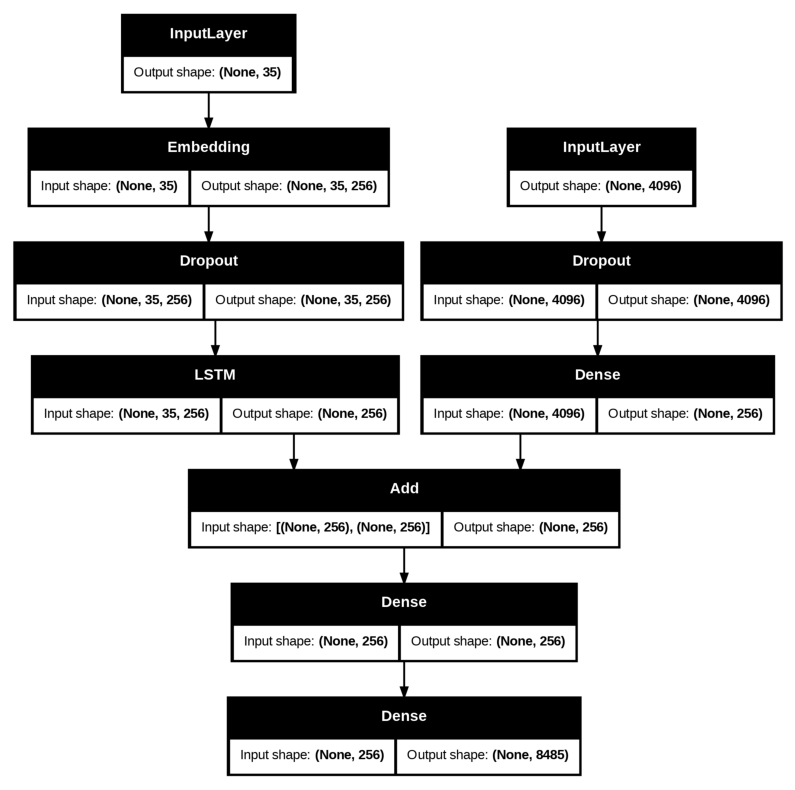

In [12]:
model = define_model(input_features, vocab_size, max_len)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 35, 256)   │  2,172,160 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 4096)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 35, 256)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [13]:
!pip install tensorflow

In [17]:
history = []
epochs = 20
batch_size = 32
steps = len(train) // batch_size
import tensorflow as tf
generator = data_generator(train, captions_dict, img_features, tokenizer, max_len, vocab_size, batch_size)

for epoch in tqdm(range(epochs), desc="Training Progress"):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    hist = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    history.append(hist.history)
    model.save(f"model_epoch_{epoch+1}.h5")


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 73s 305ms/step - accuracy: 0.0762 - loss: 6.7852


Training Progress:   5%|▌         | 1/20 [01:13<23:18, 73.60s/it]


Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 312ms/step - accuracy: 0.1224 - loss: 5.1810


Training Progress:  10%|█         | 2/20 [02:35<23:35, 78.66s/it]


Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 313ms/step - accuracy: 0.1460 - loss: 4.7097


Training Progress:  15%|█▌        | 3/20 [03:47<21:21, 75.39s/it]


Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 297ms/step - accuracy: 0.1647 - loss: 4.2735


Training Progress:  20%|██        | 4/20 [04:55<19:17, 72.36s/it]


Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 306ms/step - accuracy: 0.1923 - loss: 3.8639


Training Progress:  25%|██▌       | 5/20 [06:04<17:51, 71.46s/it]


Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 310ms/step - accuracy: 0.2216 - loss: 3.5334


Training Progress:  30%|███       | 6/20 [07:27<17:32, 75.17s/it]


Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 75s 331ms/step - accuracy: 0.2521 - loss: 3.1954


Training Progress:  35%|███▌      | 7/20 [08:42<16:18, 75.28s/it]


Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 73s 322ms/step - accuracy: 0.2756 - loss: 3.0115


Training Progress:  40%|████      | 8/20 [09:56<14:56, 74.68s/it]


Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 308ms/step - accuracy: 0.2815 - loss: 2.8938


Training Progress:  45%|████▌     | 9/20 [11:18<14:07, 77.08s/it]


Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 308ms/step - accuracy: 0.3175 - loss: 2.6988


Training Progress:  50%|█████     | 10/20 [12:28<12:29, 74.99s/it]


Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 74s 326ms/step - accuracy: 0.3295 - loss: 2.5398


Training Progress:  55%|█████▌    | 11/20 [13:43<11:13, 74.78s/it]


Epoch 12/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 307ms/step - accuracy: 0.3546 - loss: 2.4455


Training Progress:  60%|██████    | 12/20 [14:53<09:46, 73.32s/it]


Epoch 13/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 314ms/step - accuracy: 0.3868 - loss: 2.2261


Training Progress:  65%|██████▌   | 13/20 [16:15<08:52, 76.06s/it]


Epoch 14/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 304ms/step - accuracy: 0.4100 - loss: 2.0763


Training Progress:  70%|███████   | 14/20 [17:37<07:47, 77.95s/it]


Epoch 15/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 306ms/step - accuracy: 0.4422 - loss: 1.9163


Training Progress:  75%|███████▌  | 15/20 [18:47<06:17, 75.50s/it]


Epoch 16/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 308ms/step - accuracy: 0.4555 - loss: 1.7965


Training Progress:  80%|████████  | 16/20 [20:09<05:10, 77.54s/it]


Epoch 17/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 300ms/step - accuracy: 0.4841 - loss: 1.7177


Training Progress:  85%|████████▌ | 17/20 [21:18<03:44, 74.82s/it]


Epoch 18/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 311ms/step - accuracy: 0.4978 - loss: 1.6329


Training Progress:  90%|█████████ | 18/20 [22:40<02:34, 77.05s/it]


Epoch 19/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 73s 322ms/step - accuracy: 0.5163 - loss: 1.5713


Training Progress:  95%|█████████▌| 19/20 [24:03<01:18, 78.66s/it]


Epoch 20/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 303ms/step - accuracy: 0.5261 - loss: 1.5091


Training Progress: 100%|██████████| 20/20 [25:12<00:00, 75.61s/it]


In [ ]:
from tqdm.notebook import tqdm  # use `tqdm` for scripts, `tqdm.notebook` for Jupyter/Colab
import tensorflow as tf
# Training parameters
epochs = 20
batch_size = 32
steps = len(train) // batch_size
history = []

generator = data_generator(train, captions_dict, img_features, tokenizer, max_len, vocab_size, batch_size)


# Training loop
for epoch in tqdm(range(epochs), desc="Training Progress"):

    print(f"\nEpoch {epoch + 1}/{epochs}")
    hist = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    history.append(hist)


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.0734 - loss: 6.8444

Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1147 - loss: 5.2585

Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1448 - loss: 4.7027

Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1690 - loss: 4.2517

Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1954 - loss: 3.7904

Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2172 - loss: 3.4766

Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2465 - loss: 3.2272

Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2776 - loss: 2.9566

Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2912 - loss: 2.7387

Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3280 - loss: 2.5913

Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3381 - loss: 2.4353

Epoch 12/20
227/227 ━━━━━━━━━

# Save Model

In [18]:
model.save("Model Building/model.h5")

In [ ]:
with open("Model Building/history.pkl", "wb") as f:
  pickle.dump(history, f)